In [148]:
import pandas as pd

In [149]:
def clean_data(historical_data:pd.DataFrame) -> pd.DataFrame:
    """
    Transforms sales data into total sales per month

    Args:
        historical_data: historical sales dataframe (date, store, item, sales)

    Returns:
        monthly sales dataframe (date, sales)
    """
    historical_data["date"] = pd.to_datetime(historical_data["date"])
    historical_data["date"] = historical_data["date"].dt.year.astype("str") + "-" + historical_data["date"].dt.month.astype("str") + "-01"
    historical_data["date"] = pd.to_datetime(historical_data["date"])
    historical_data = historical_data.groupby("date").sales.sum().reset_index()
    return historical_data

<Axes: title={'center': 'Monthly Sales'}, xlabel='date'>

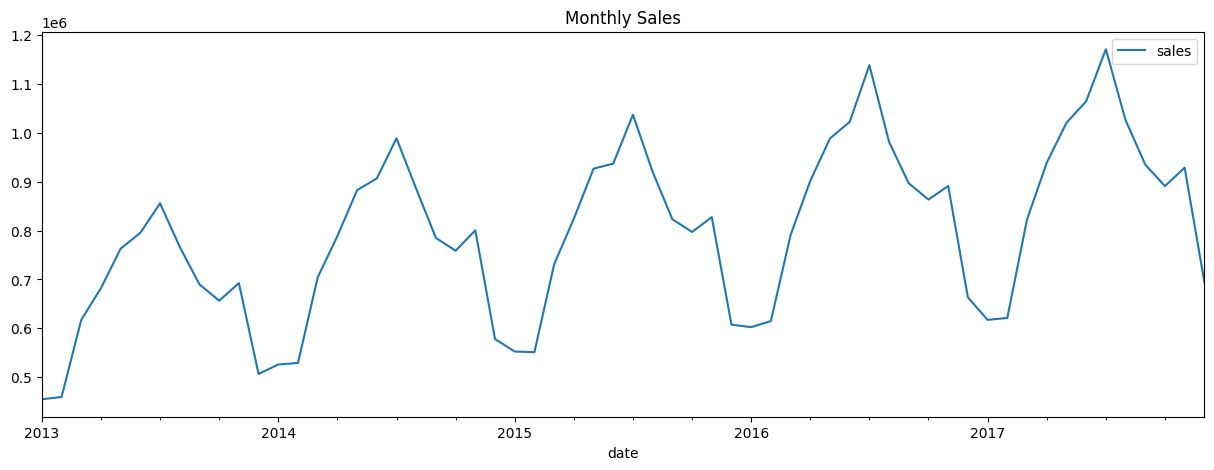

In [150]:
DATA_PATH = "historical_data.csv"
df_sales = pd.read_csv(DATA_PATH)
cleaned_data = clean_data(df_sales)
# Plot
cleaned_data.plot(x="date", y="sales", figsize=(15, 5), title="Monthly Sales")

In [151]:
def filter_data(cleaned_data:pd.DataFrame, prediction_year:str) -> pd.DataFrame:
    """
    Filters data to include only data from the two years before the prediction year

    Args:
        cleaned_data: monthly sales dataframe (date, sales)
        prediction_year: year to predict

    Returns:
        filtered dataframe (date, sales)
    """
    start_date = str(int(prediction_year) - 2) + "-01-01"
    end_date = str(int(prediction_year) - 1) + "-12-01"
    filtered_data = cleaned_data[(cleaned_data["date"] >= start_date) & (cleaned_data["date"] <= end_date)]
    return filtered_data

<Axes: title={'center': 'Monthly Sales'}, xlabel='date'>

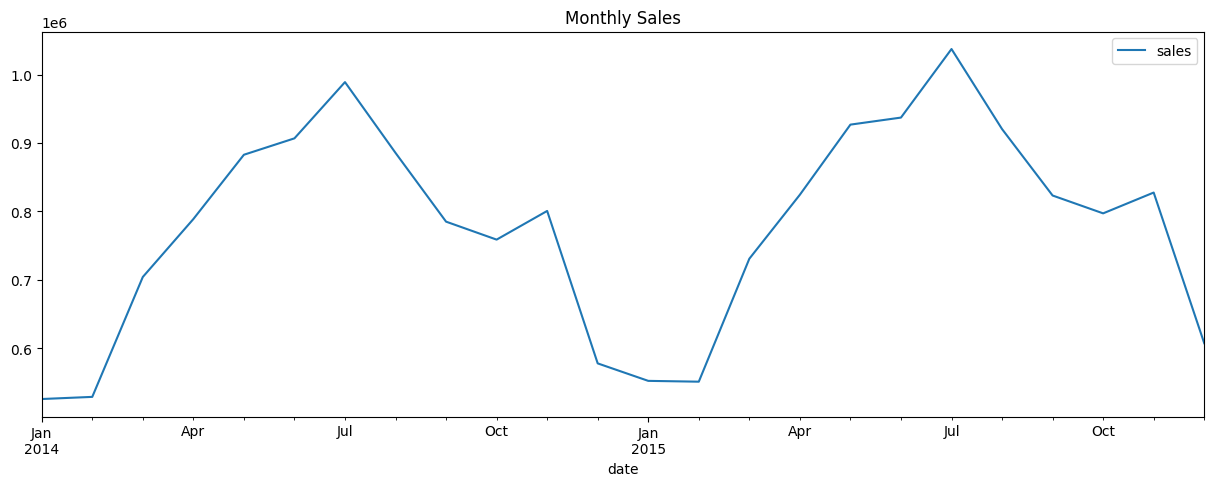

In [152]:
year = "2016"
last_two_years = filter_data(cleaned_data, year)
# Plot
last_two_years.plot(x="date", y="sales", figsize=(15, 5), title="Monthly Sales")

In [153]:
last_two_years

,date,sales
12,2014-01-01,525987
13,2014-02-01,529117
14,2014-03-01,704301
15,2014-04-01,788914
16,2014-05-01,882877
17,2014-06-01,906842
18,2014-07-01,989010
19,2014-08-01,885596
20,2014-09-01,785124
21,2014-10-01,758883


In [154]:
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

In [166]:
def predict(last_two_years:pd.DataFrame, model:str) -> pd.DataFrame:
    """
    Predicts sales for the prediction year according to the model

    Args:
        last_two_years: filtered dataframe (date, sales)
        model: model to use for prediction (linear, arima)
    
    Returns:
        predicted sales for the prediction year (date, sales)
    """
    predicted_data = pd.DataFrame()

    if model == "linear":
        # Linear Regression
        X = last_two_years.index.values.reshape(-1, 1)
        y = last_two_years["sales"].values.reshape(-1, 1)
        model = LinearRegression()
        model.fit(X, y)
        predicted_data["date"] = pd.date_range(start="2016-01-01", end="2016-12-01", freq="MS")
        predicted_data["sales"] = model.predict(pd.DataFrame({"date": predicted_data["date"].astype("str")}).index.values.reshape(-1, 1))
    elif model == "arima":
        train_data = last_two_years.copy()
        train_data.set_index("date", inplace=True)
        model = sm.tsa.statespace.SARIMAX(last_two_years["sales"], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
        results = model.fit()
        predicted_data = results.predict(12)
        # Cut the first row
        predicted_data = predicted_data[1:]
        predicted_data = pd.DataFrame({"date": pd.date_range(start="2016-02-01", end="2016-12-01", freq="MS"), "sales": predicted_data.values})
    else:
        raise ValueError("Model not supported")
    return predicted_data

In [167]:
prediction = predict(last_two_years, "arima")
prediction

c:\Users\asaju\Desktop\yearly_prediction\yearly_prediction\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\asaju\Desktop\yearly_prediction\yearly_prediction\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\asaju\Desktop\yearly_prediction\yearly_prediction\venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\asaju\Desktop\yearly_prediction\yearly_prediction\venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to conv

,date,sales
0,2016-02-01,5.485411e+05
1,2016-03-01,7.365660e+05
2,2016-04-01,8.120759e+05
3,2016-05-01,9.262177e+05
4,2016-06-01,9.470546e+05
5,2016-07-01,1.023525e+06
6,2016-08-01,9.314401e+05
7,2016-09-01,8.162429e+05
8,2016-10-01,7.987337e+05
9,2016-11-01,8.377092e+05


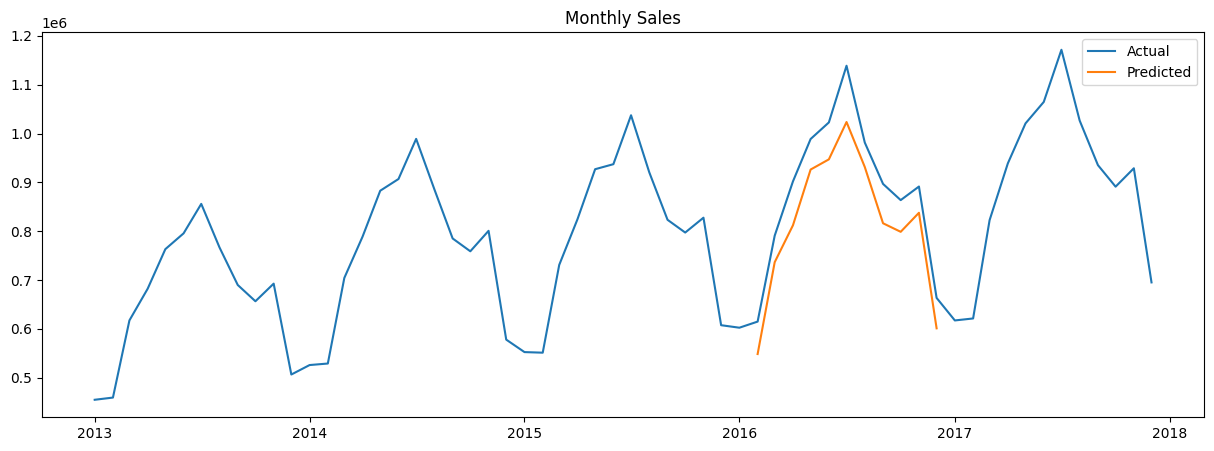

In [168]:
import matplotlib.pyplot as plt
# Plot both actual and predicted sales
plt.figure(figsize=(15, 5))
plt.plot(cleaned_data["date"], cleaned_data["sales"], label="Actual")
plt.plot(prediction["date"], prediction["sales"], label="Predicted")
plt.title("Monthly Sales")
plt.legend()
plt.show()